# Global

In [41]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing",
    'mesh_full_data_url': "https://drive.google.com/drive/folders/1p9vh4MInKRFFRUwOUbM7dAm0C6ObM9-5?usp=drive_link",

    # Networks
    'hidden_dim' : 256,
    'print_debug' : True,
    'verts_dim' : 3,
    'emb_net_depth' : 4,
    'disp_dim' : 1,
    'disp_net_depth' : 2,
    'norm_ratio' : 0.1,

    # Rendering
    'rendered_items' : 4,
    'net_rendered_items' : 16
}

# Imports

In [2]:
!pip install open3d gdown --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [18]:
import gdown
import locale
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import plotly.graph_objects as go
import sys
import torch
import torch.nn as nn

from google.colab import output
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [4]:
# Pytorch 3D utilities
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.utils import ico_sphere

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 790.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=8cef3ac6ba91b3a2d51c2c61bdc746651c6bac245fab5ccdeb3d4363b77a110d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=464372ae97381451def1febd8e8819a625f32c757745ef62feb65bd8d579aa70
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 123.3 MB/s eta 0:00:00


# Utils

In [109]:
def device_setup():
    """
        Initialize GPU
    """
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print("[LOG] Currently working on", device)
    return device

def download_dataset(quiet=False,reset=False,full=True):
  if reset:
    locale.getpreferredencoding = lambda: "UTF-8"
    !rm -r mesh_data

  if full:
    dataset_url = global_var['mesh_full_data_url']
    dataset_str = "full"
  else:
    dataset_url = global_var['mesh_data_url']
    dataset_str = "test"

  if not os.path.exists(global_var['mesh_data_path']):
    print(f"[LOG] Starting {dataset_str} dataset download...")
    gdown.download_folder(url = dataset_url,
        output = global_var['mesh_data_path'],
        quiet=False)
    print(f"[LOG] Download of {dataset_str} dataset ended!")

  else:
    print("[LOG] Mesh dataset already downloaded!")

def image_grid(images,rows=None,cols=None,fill=True,show_axes=False,rgb=True):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()

    plt.show()

def get_dataset_paths(dataset_path):
    """
        Return a list of all elements path in the dataset
    """
    meshes_paths = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)

    meshes_paths.sort()
    return meshes_paths

# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, renderer,
                         target_image, title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

def final_pointcloud(src_mesh,final_mesh):
    # Sample points uniformly from the surface of the mesh.
    src_points = sample_points_from_meshes(src_mesh, 20000)
    src_x, src_y, src_z = src_points.clone().detach().cpu().squeeze().unbind(1)

    final_points = sample_points_from_meshes(final_mesh, 20000)
    final_x, final_y, final_z = final_points.clone().detach().cpu().squeeze().unbind(1)

    fig = plt.figure(figsize=(16, 16))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter3D(src_x, src_z, -src_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title("Target mesh")
    ax.view_init(190, 30)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter3D(final_x, final_z, -final_y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title("Deformed source")
    ax.view_init(190, 30)

    plt.show()

def mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50
          )

    return fig

def initial_mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True)
            )
        )
    )

    return fig

In [6]:
# Allow third part libraries
output.enable_custom_widget_manager()

# GPU Setup
device = device_setup()

[LOG] Currently working on cuda:0


# Dataset

## Download dataset

In [53]:
download_dataset(quiet=False,reset=False,full=False)
meshes_paths = get_dataset_paths(global_var['mesh_data_path'])

[LOG] Starting test dataset download...


Retrieving folder list


Retrieving folder 1x6gVgkruSa8lv4BR69VdlVl8nh4cWLOa f8b6bcf0dcf240e567e4c36fcbad1d04
Retrieving folder 1dfj5MUR_bNwbvpl3mWXSikFzifhuhQ_W images
Processing file 1a0Jcya7pJUwB7GUA5bL7SKCsb7RzSoHX texture0.jpg
Processing file 1vDsDW5tZoez4dasg1ipLRDDATE465q88 texture1.jpg
Processing file 18nc7npIzpHMH1XBni928FgfHBbEZbtfz texture2.jpg
Retrieving folder 1m9nZTB99KP5H1kKp0o6_b1vbCwh4WqpR models
Processing file 1FLDAkCl1va_rWEyES3_ZXfEwMkhYxDmq model_normalized.json
Processing file 1WZzrbRsTw4rIcpfiT4fa7nVur-8EGjhz model_normalized.mtl
Processing file 1d461W71vO7if_m5Q0Dx7E37Ryl7u2Ne6 model_normalized.obj
Processing file 1qL05tDjLO1Q3GYQQzwjQeinI6OJ5AwS0 model_normalized.solid.binvox
Processing file 1t97Lage7y0bjBVDcsvD3ROovSCLoJ2fc model_normalized.surface.binvox
Retrieving folder 1-tZ0Q2JpnWy3z8O9GUGHIRL2uCWKWxIY f97df3db44133969fe42c1e9e335e7fc
Retrieving folder 12qoqu0EqM0rPm5X1emj_wMySH1CdUKA6 images
Processing file 1iMU_XlIBz5QaVFvZyXJfOhDS_DlVnVas texture0.jpg
Processing file 1lZqKFJJO

Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1a0Jcya7pJUwB7GUA5bL7SKCsb7RzSoHX
To: /content/mesh_data/f8b6bcf0dcf240e567e4c36fcbad1d04/images/texture0.jpg
100%|██████████| 14.7k/14.7k [00:00<00:00, 36.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vDsDW5tZoez4dasg1ipLRDDATE465q88
To: /content/mesh_data/f8b6bcf0dcf240e567e4c36fcbad1d04/images/texture1.jpg
100%|██████████| 343k/343k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=18nc7npIzpHMH1XBni928FgfHBbEZbtfz
To: /content/mesh_data/f8b6bcf0dcf240e567e4c36fcbad1d04/images/texture2.jpg
100%|██████████| 29.0k/29.0k [00:00<00:00, 55.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FLDAkCl1va_rWEyES3_ZXfEwMkhYxDmq
To: /content/mesh_data/f8b6bcf0dcf240e567e4c36fcbad1d04/models/model_normalized.json
100%|██████████| 217/217 [00:00<00:00, 827kB/s]
Downloading...
From: https://drive.google.com/uc?id=1WZzrbRsTw4rIcpfiT4fa7nVu

[LOG] Download of test dataset ended!



Download completed


## Target 3D shape

In [54]:
# Load obj file
mesh = load_objs_as_meshes([meshes_paths[9]], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## 2D guidance acquisition

In [55]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different
# viewing angles. All the cameras helper methods support mixed type inputs and
# broadcasting. So we can view the camera from the a distance of dist=2.7, and
# then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

# Define the settings for rasterization and shading. Here we set the output
# image to be of size 128X128. As we are rendering images for visualization
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
# rasterize_meshes.py for explanations of these parameters.  We also leave
# bin_size and max_faces_per_bin to their default values of None, which sets
# their values using heuristics and ensures that the faster coarse-to-fine
# rasterization method is used.  Refer to docs/notes/renderer.md for an
# explanation of the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured
# Phong shader will interpolate the texture uv coordinates for each vertex,
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
                                           T=T[None, i, ...]) for i in range(num_views)]

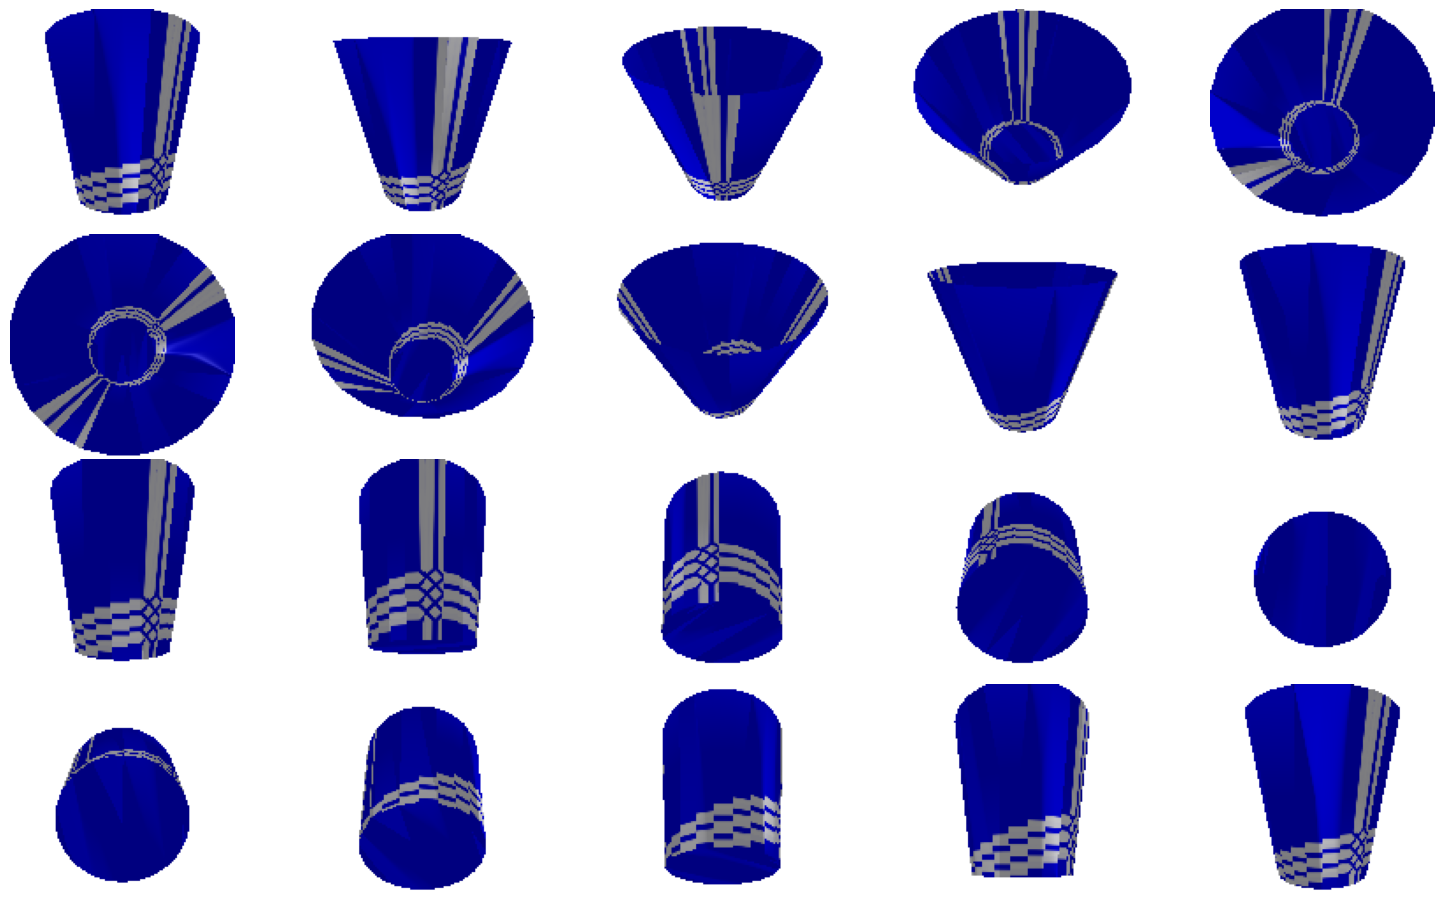

In [56]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)

## 2D guidance rasterization

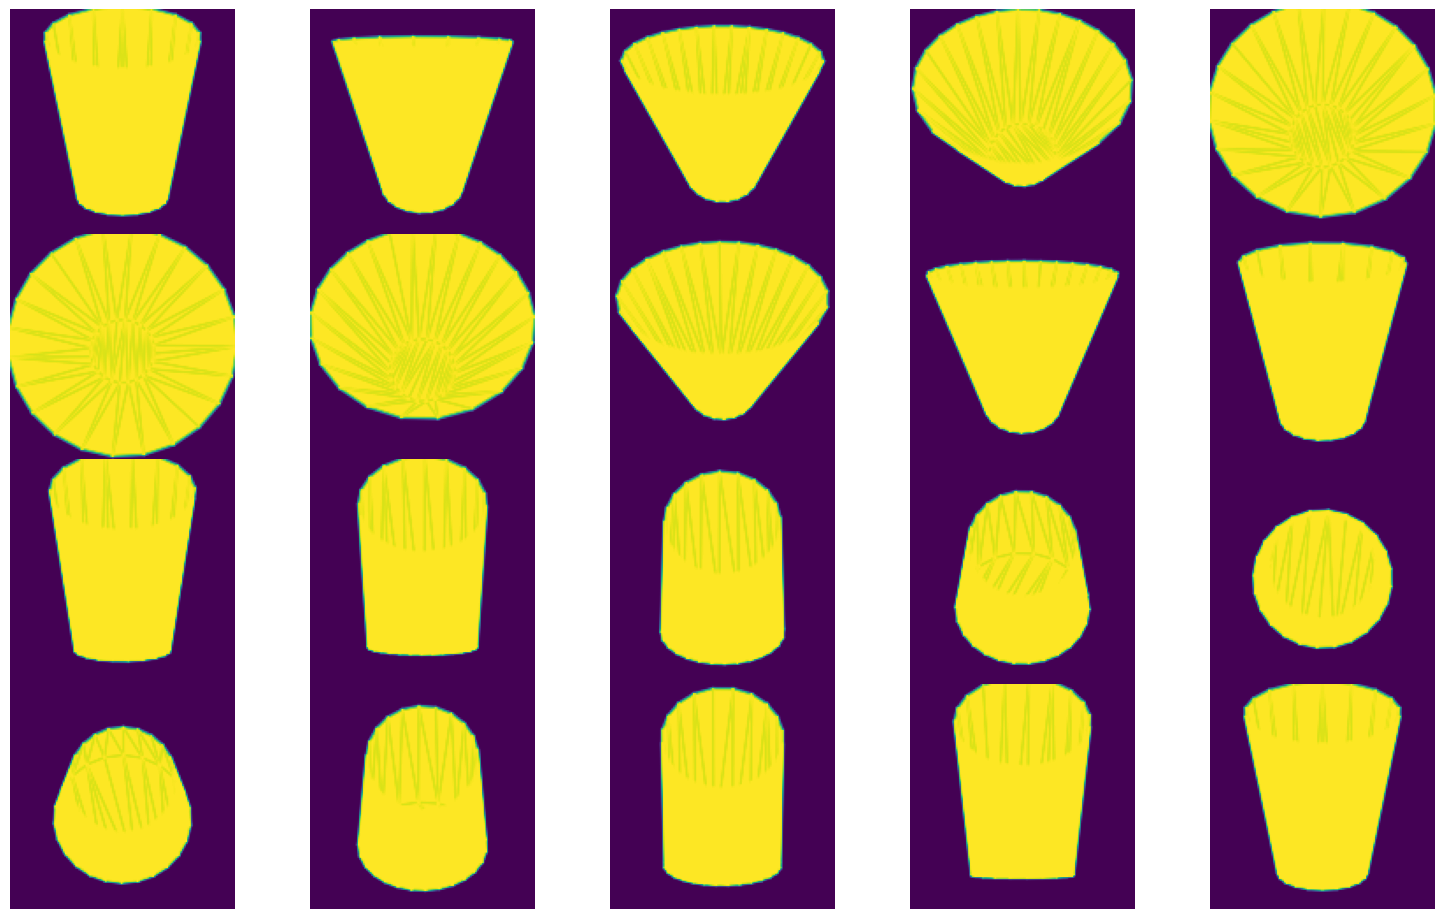

In [57]:
# Rasterization settings for silhouette rendering
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)

## Source 3D shape

In [97]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device) # OLD ----------------
# Ottenere il path per la visualizzazione della sfera
# # Load obj file
# src_mesh = load_objs_as_meshes([meshes_paths[3]], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
src_verts = src_mesh.verts_packed()
src_N = src_verts.shape[0]
src_center = src_verts.mean(0)
src_scale = max((src_verts - src_center).abs().max(0)[0])
src_mesh.offset_verts_(-src_center)
src_mesh.scale_verts_((1.0 / float(src_scale)));

final_fig = initial_mesh_visualization(meshes_paths[3])
final_fig.show()

## Initial mesh rasterization for loss computation

In [98]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

# Loss

In [99]:
# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

In [100]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Train

In [101]:
class OffsetNet(nn.Module):
  def __init__(self, verts_dim=3, hidden_dim=256, disp_dim=3, norm_ratio=0.1):
    super(OffsetNet, self).__init__()

    self.l1 = nn.Linear(verts_dim,hidden_dim)
    self.a1 = nn.ReLU()
    self.l2 = nn.Linear(hidden_dim,hidden_dim)
    self.a2 = nn.ReLU()
    self.l3 = nn.Linear(hidden_dim,disp_dim)
    self.norm_ratio = norm_ratio

  def forward(self,x):
    x = self.l1(x)
    x = self.a1(x)
    x = self.l2(x)
    x = self.a2(x)
    x = self.l3(x) * self.norm_ratio

    return x

In [27]:
class OffsetNet(nn.Module):
    def __init__(self, verts_dim=3, hidden_dim=256, disp_dim=3, norm_ratio=0.1):
        super(OffsetNet, self).__init__()

        # Positional Encoding
        self.pos_enc_layer = nn.Linear(verts_dim,hidden_dim)
        self.pos_enc_act = nn.ReLU()

        # Vertices embedding
        self.vert_emb_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_1 = nn.ReLU()
        self.vert_emb_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_2 = nn.ReLU()
        self.vert_emb_layer_3 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_3 = nn.ReLU()
        self.vert_emb_layer_4 = nn.Linear(hidden_dim, hidden_dim)
        self.vert_emb_act_4 = nn.ReLU()

        # Displacement prediction
        self.disp_pred_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.disp_pred_act_1 = nn.ReLU()
        self.disp_pred_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.disp_pred_act_2 = nn.ReLU()
        self.disp_pred_layer_3 = nn.Linear(hidden_dim, disp_dim)
        self.disp_pred_act_3 = nn.Tanh()
        self.norm_ratio = norm_ratio

    def forward(self, x):
        # pos_enc_layer_out = self.pos_enc_layer(x)
        pos_enc_layer_out = torch.nn.functional.linear(x,self.pos_enc_layer.weight.clone(),self.pos_enc_layer.bias)
        pos_enc_act_out = self.pos_enc_act(pos_enc_layer_out)

        # vert_emb_layer_out_1 = self.vert_emb_layer_1(pos_enc_act_out)
        vert_emb_layer_out_1 = torch.nn.functional.linear(pos_enc_act_out,self.vert_emb_layer_1.weight.clone(),self.vert_emb_layer_1.bias)
        vert_emb_act_out_1 = self.vert_emb_act_1(vert_emb_layer_out_1)

        # vert_emb_layer_out_2 = self.vert_emb_layer_2(vert_emb_act_out_1)
        vert_emb_layer_out_2 = torch.nn.functional.linear(vert_emb_act_out_1,self.vert_emb_layer_2.weight.clone(),self.vert_emb_layer_2.bias)
        vert_emb_act_out_2 = self.vert_emb_act_2(vert_emb_layer_out_2)

        # vert_emb_layer_out_3 = self.vert_emb_layer_3(vert_emb_act_out_2)
        vert_emb_layer_out_3 = torch.nn.functional.linear(vert_emb_act_out_2,self.vert_emb_layer_3.weight.clone(),self.vert_emb_layer_3.bias)
        vert_emb_act_out_3 = self.vert_emb_act_3(vert_emb_layer_out_3)

        # vert_emb_layer_out_4 = self.vert_emb_layer_4(vert_emb_act_out_3)
        vert_emb_layer_out_4 = torch.nn.functional.linear(vert_emb_act_out_3,self.vert_emb_layer_4.weight.clone(),self.vert_emb_layer_4.bias)
        vert_emb_act_out_4 = self.vert_emb_act_4(vert_emb_layer_out_4)

        # disp_pred_layer_out_1 = self.disp_pred_layer_1(vert_emb_act_out_4)
        disp_pred_layer_out_1 = torch.nn.functional.linear(vert_emb_act_out_4,self.disp_pred_layer_1.weight.clone(),self.disp_pred_layer_1.bias)
        disp_pred_act_out_1 = self.disp_pred_act_1(disp_pred_layer_out_1)

        # disp_pred_layer_out_2 = self.disp_pred_layer_2(disp_pred_act_out_1)
        disp_pred_layer_out_2 = torch.nn.functional.linear(disp_pred_act_out_1,self.disp_pred_layer_2.weight.clone(),self.disp_pred_layer_2.bias)
        disp_pred_act_out_2 = self.disp_pred_act_2(disp_pred_layer_out_2)

        # disp_pred_layer_out_3 = self.disp_pred_layer_3(disp_pred_act_out_2)
        disp_pred_layer_out_3 = torch.nn.functional.linear(disp_pred_act_out_2,self.disp_pred_layer_3.weight.clone(),self.disp_pred_layer_3.bias)
        out = self.disp_pred_act_3(disp_pred_layer_out_3) * self.norm_ratio


        return out

In [102]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True) # Questo corrisponde all'offset da dare ai vertici

model = OffsetNet(
    verts_dim=verts_shape[1],
    hidden_dim = 256,
    disp_dim = 3,
    norm_ratio = 0.1).to(device)

# The optimizer
# optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

Train:   0%|          | 0/2000 [00:00<?, ?/s]

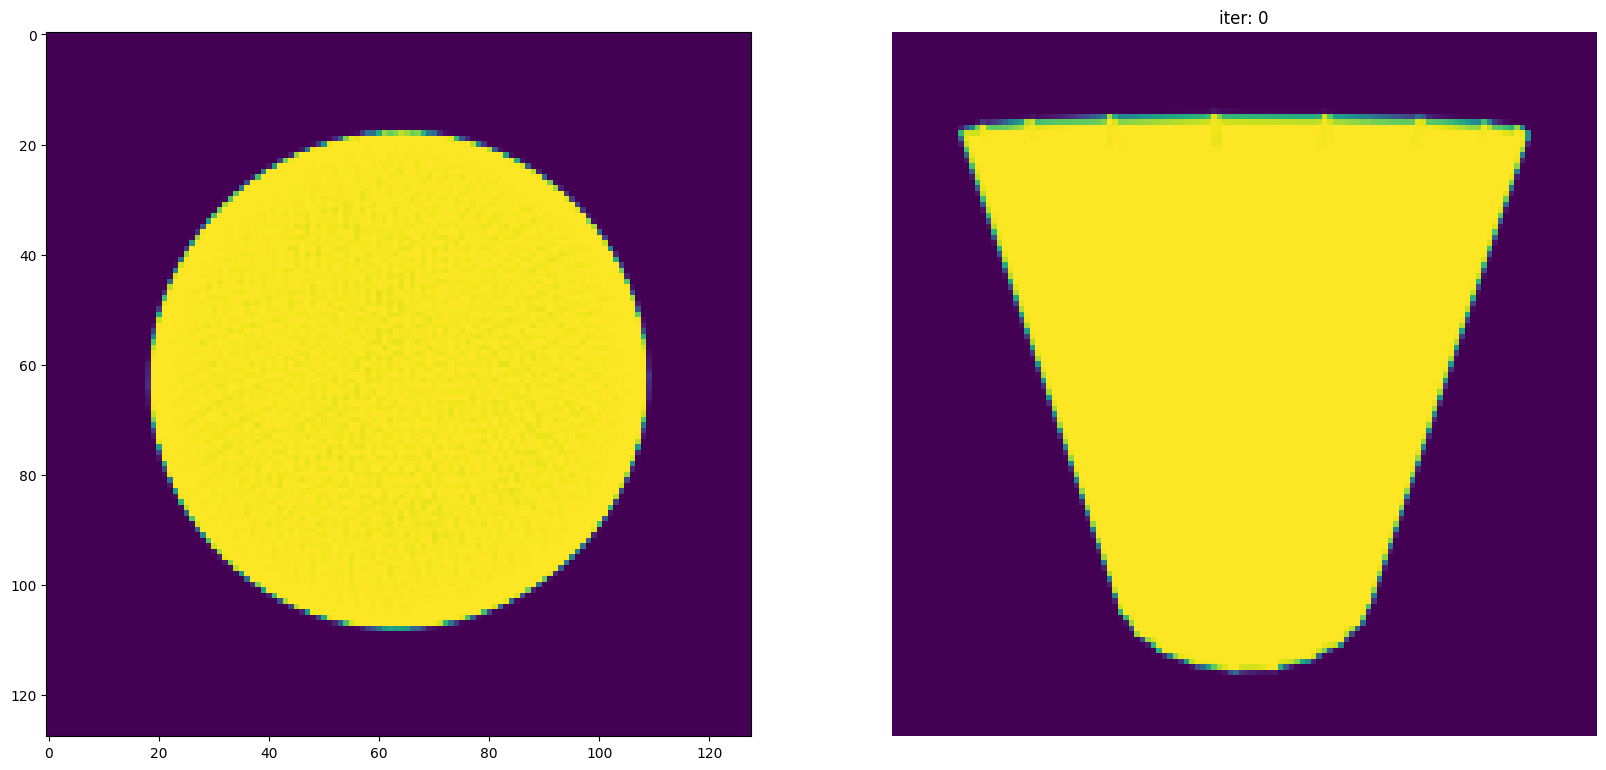

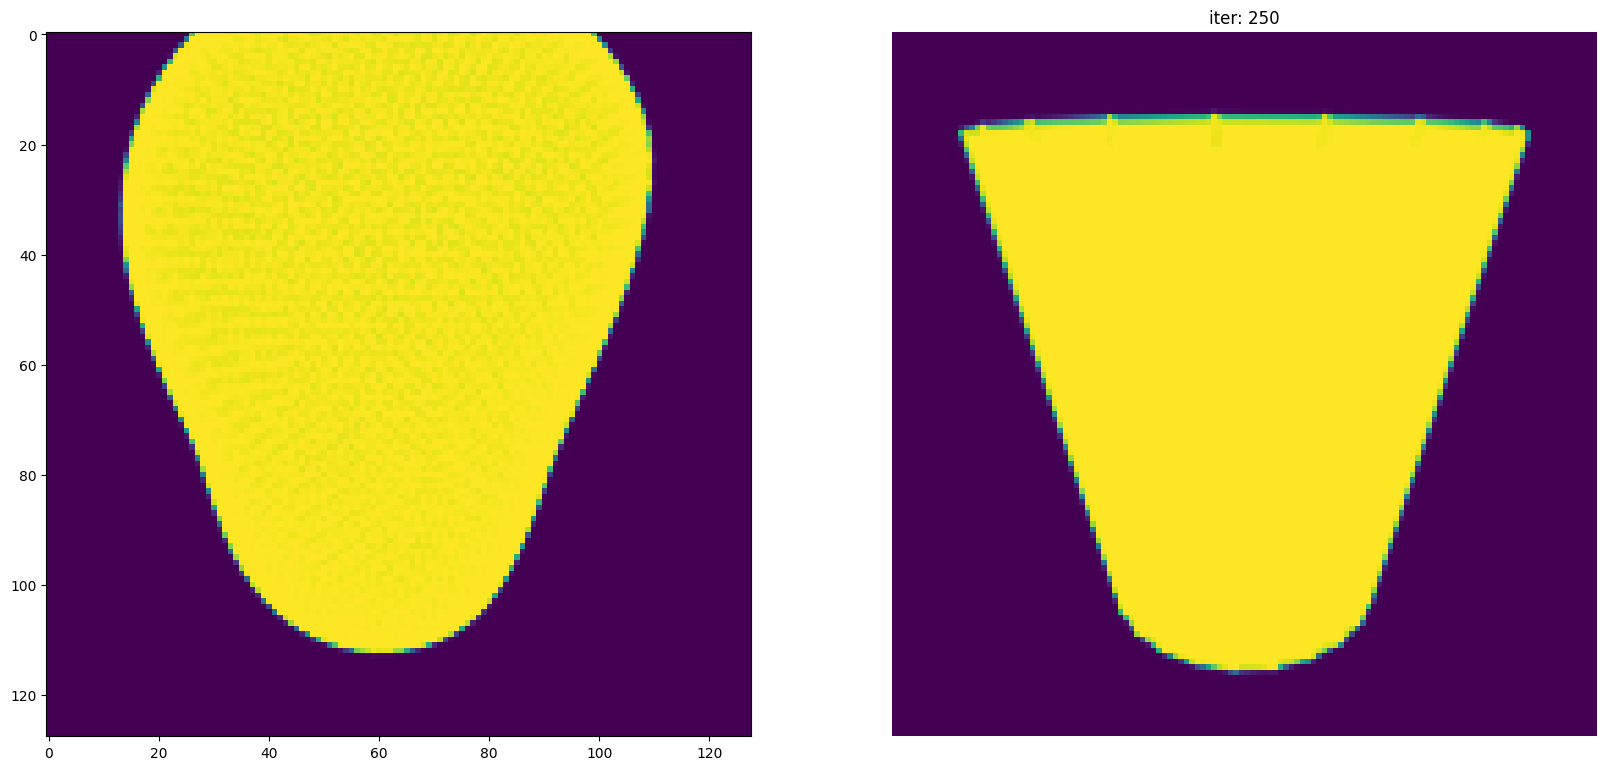

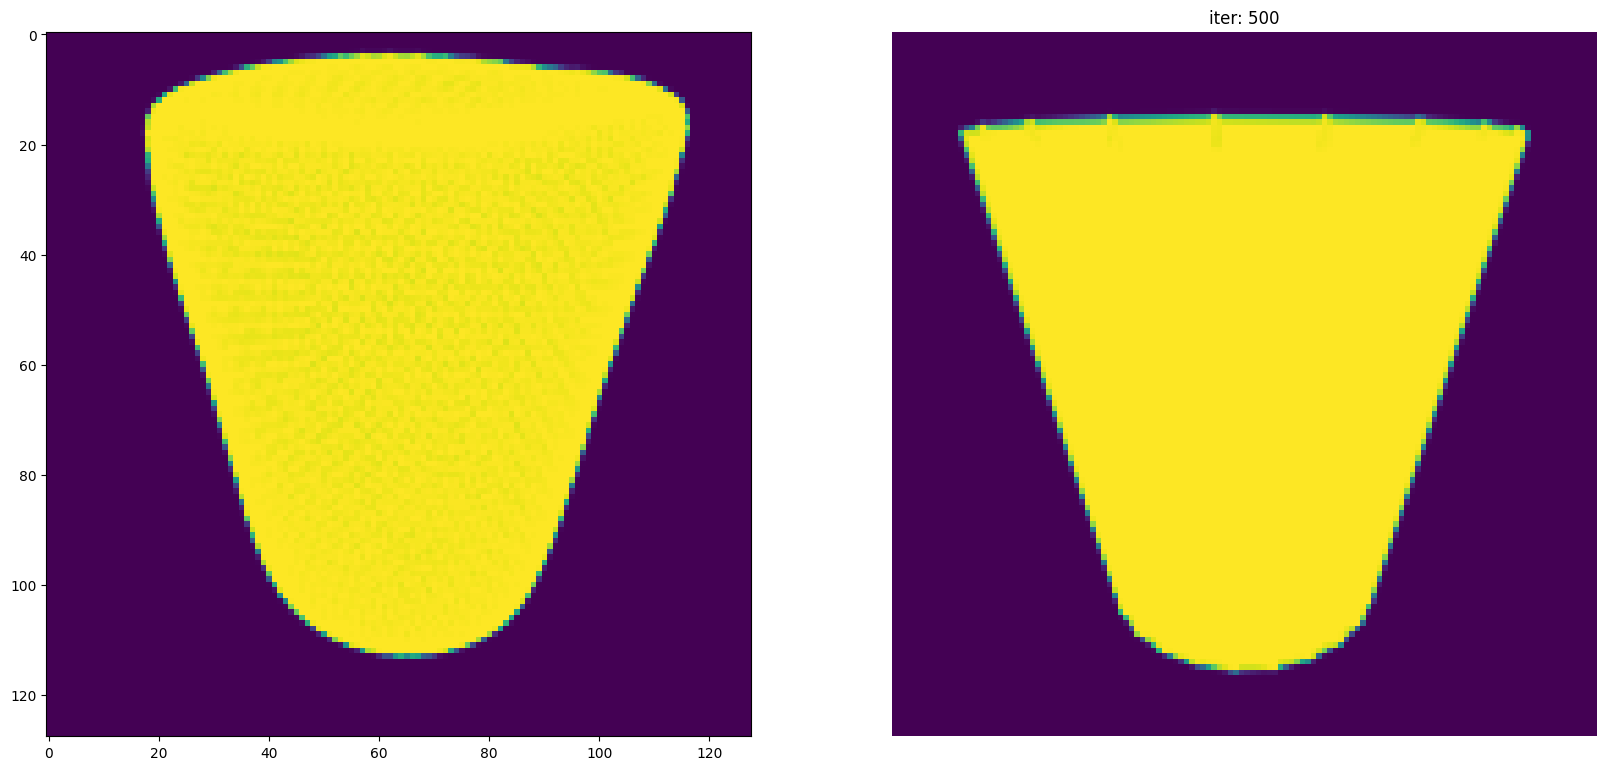

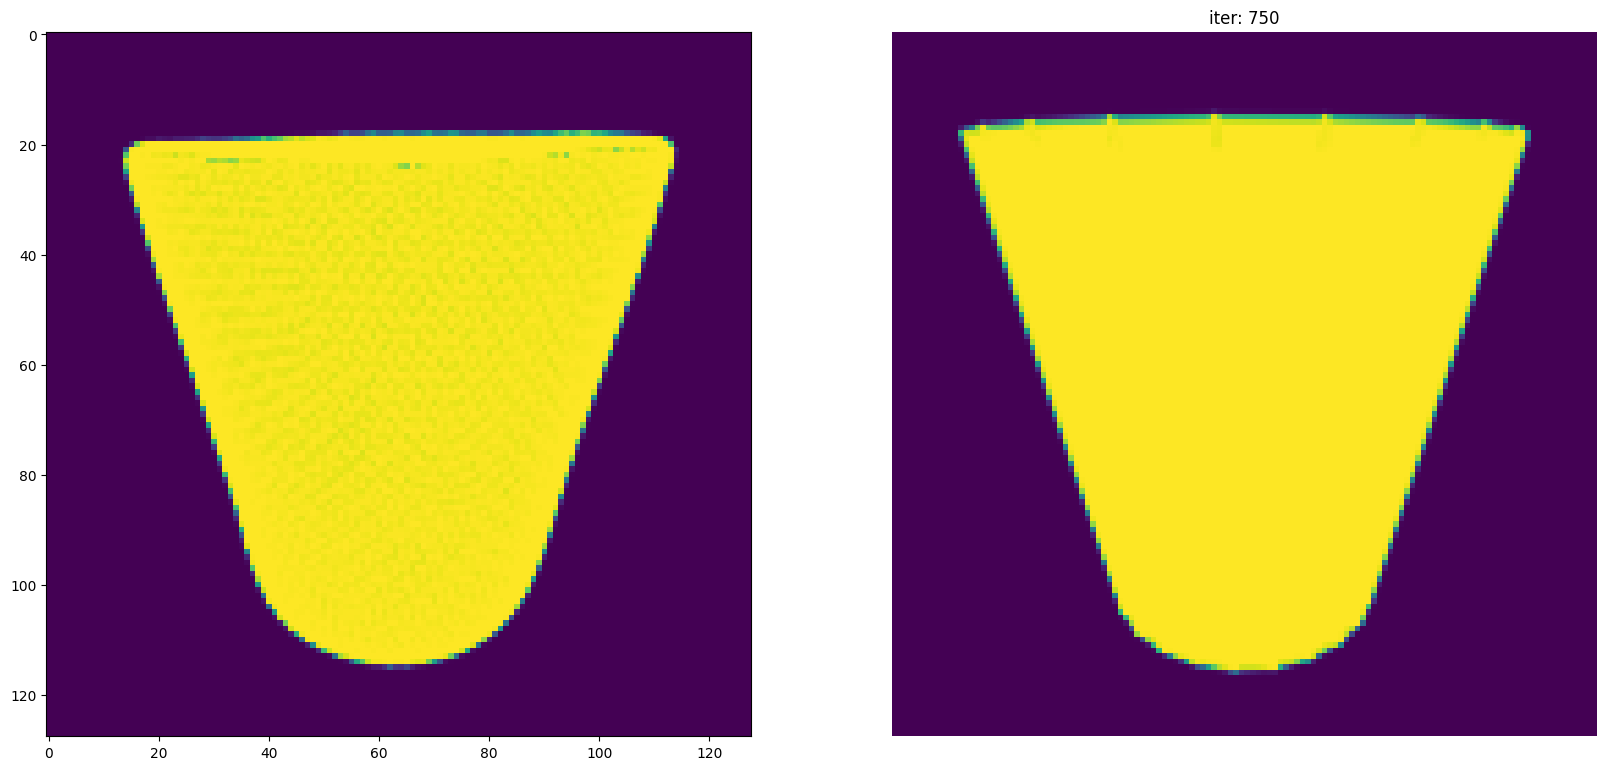

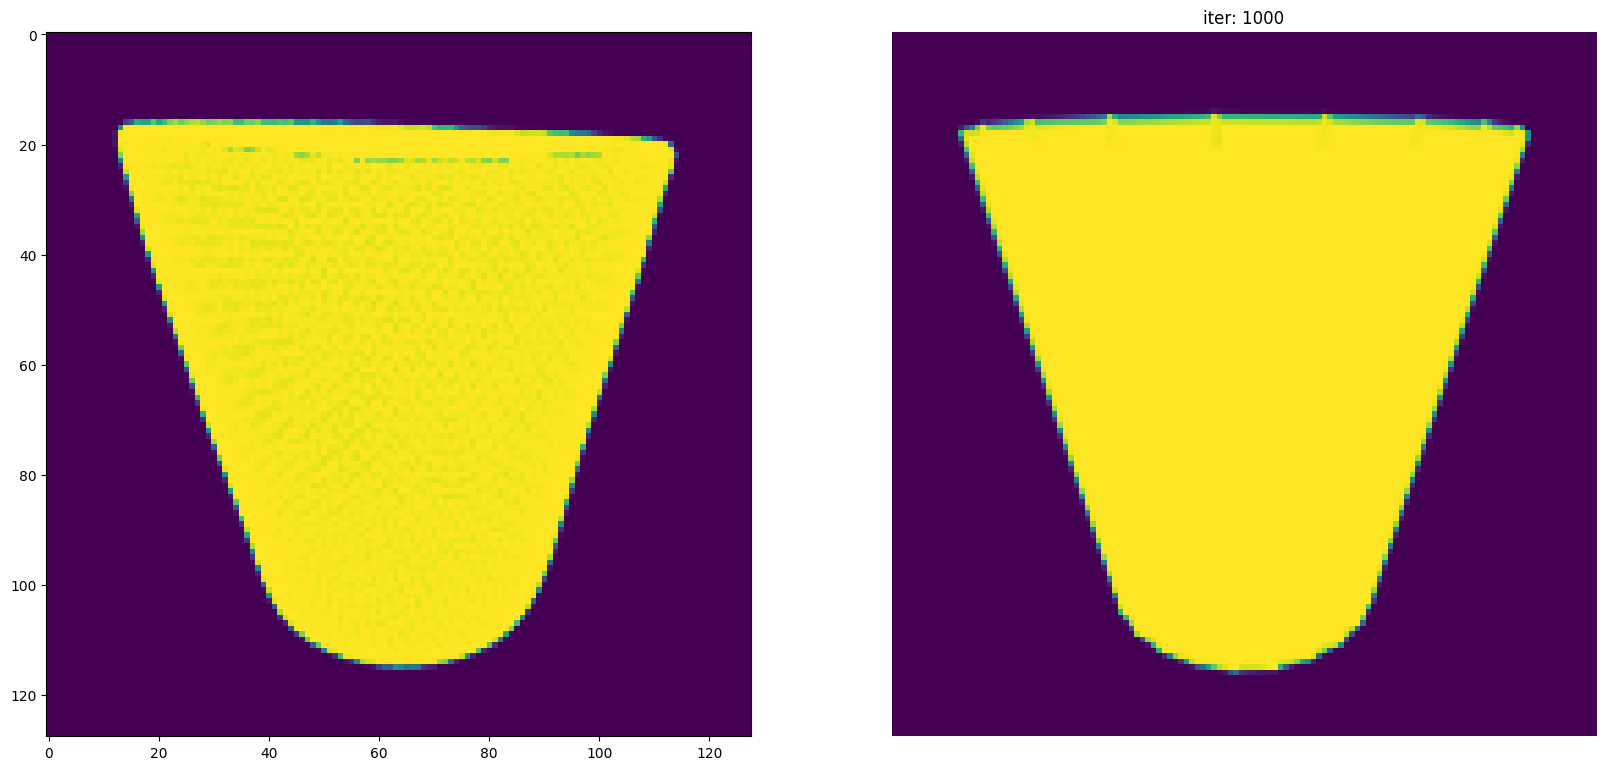

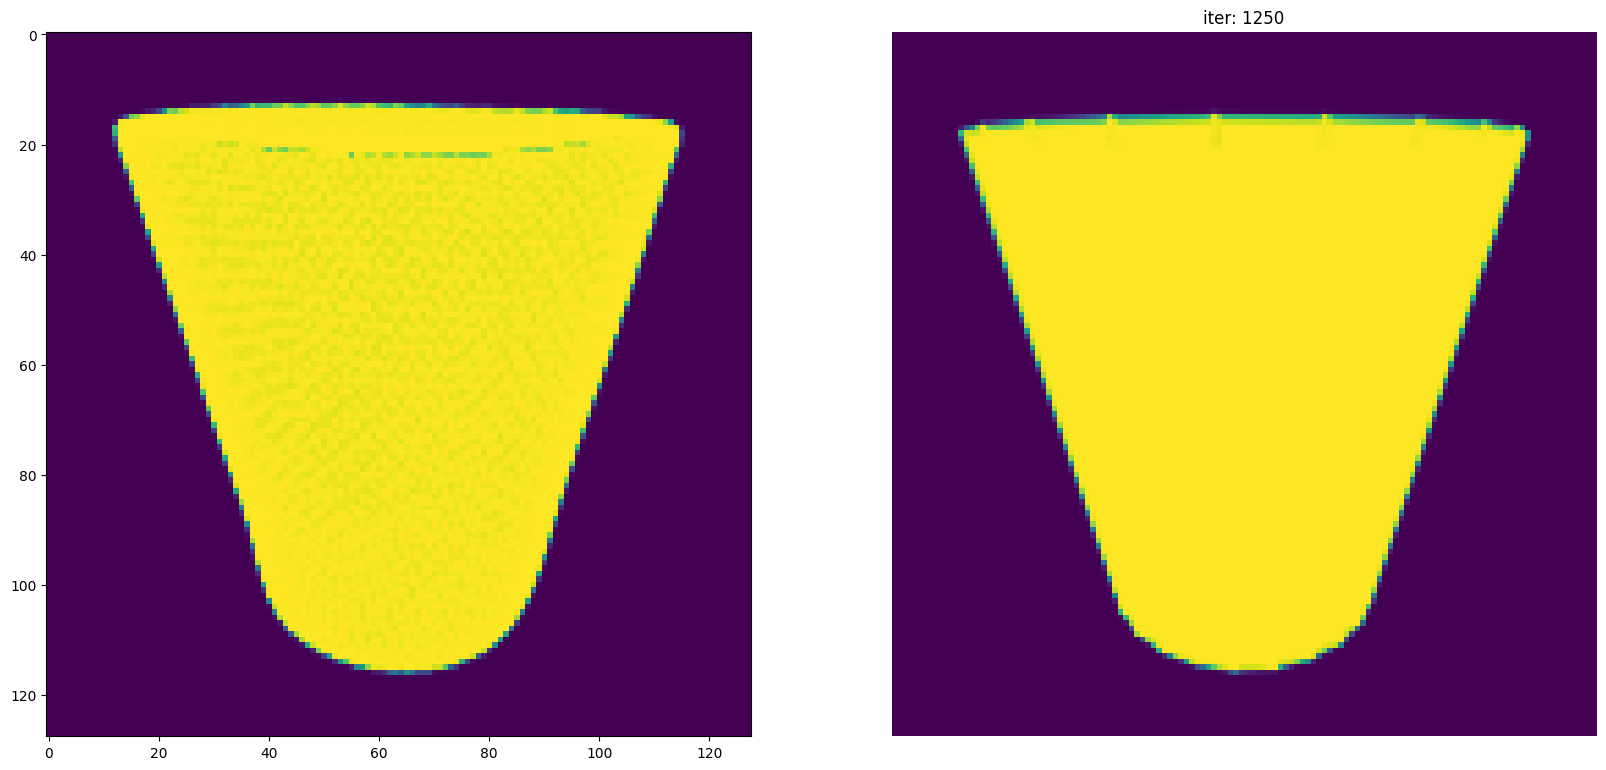

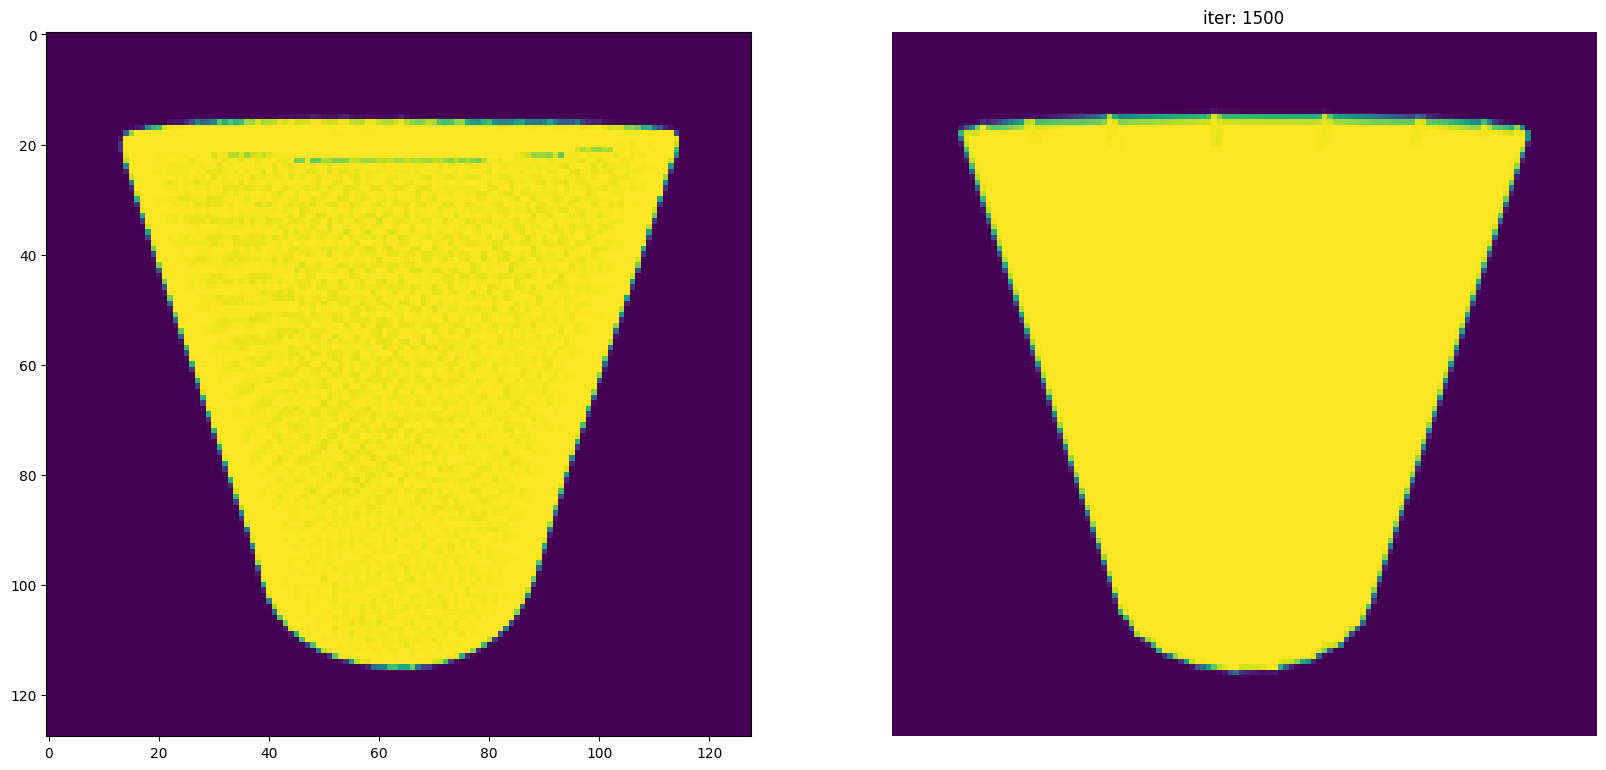

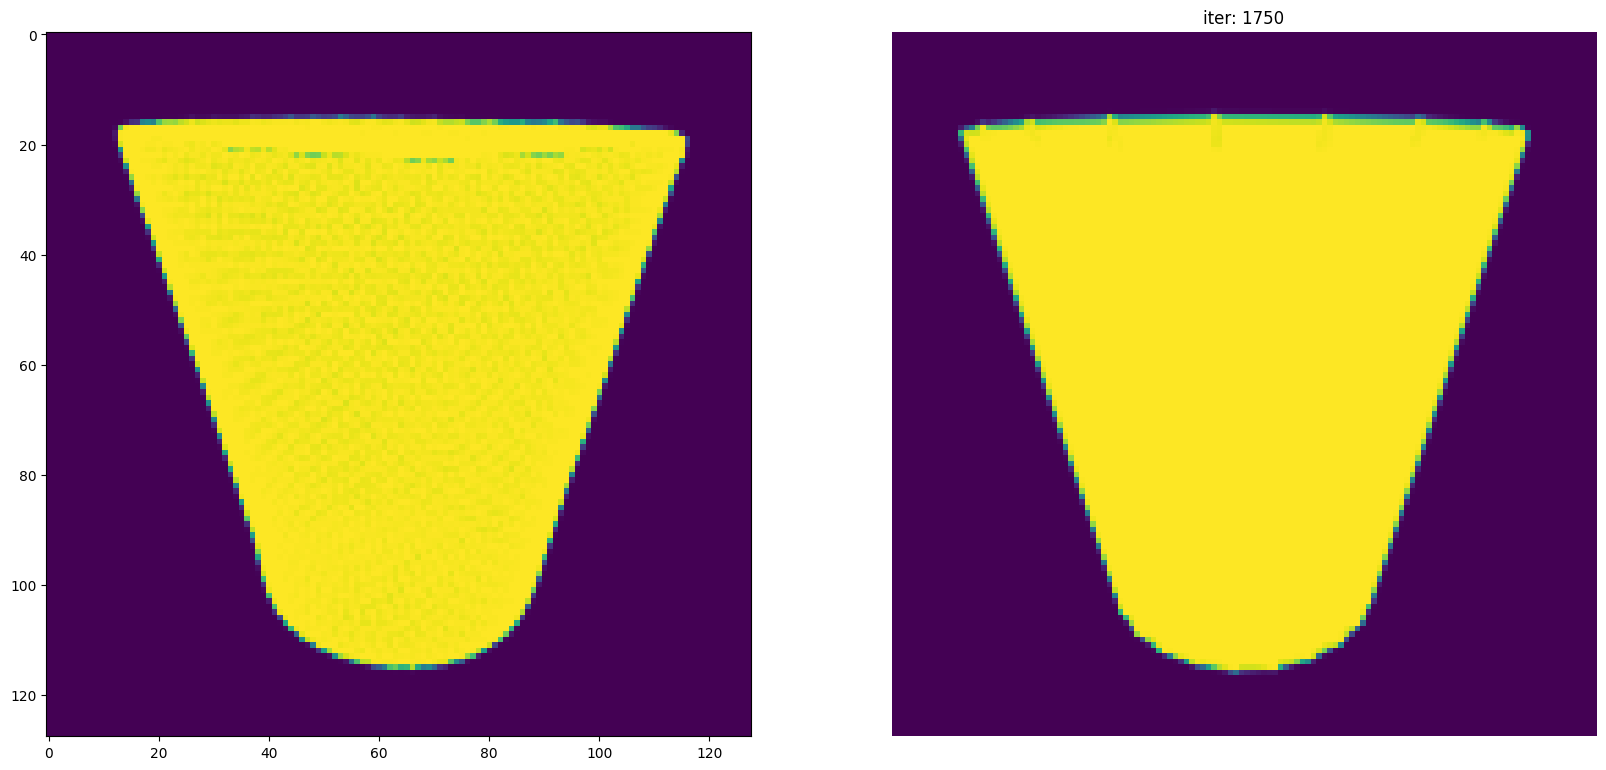

In [103]:
with trange(Niter,desc="Train", unit="", position=0, leave=True) as loop:
  for i in loop:
      # Initialize optimizer
      model.train()
      optimizer.zero_grad()

      # Predict deformation
      inputs = src_mesh.verts_packed().to(device)
      deform_verts = model(inputs)

      # Deform the mesh
      new_src_mesh = src_mesh.offset_verts(deform_verts)

      # Losses to smooth /regularize the mesh shape
      loss = {k: torch.tensor(0.0, device=device) for k in losses}
      update_mesh_shape_prior_losses(new_src_mesh, loss)

      # Compute the average silhouette loss over two random views, as the average
      # squared L2 distance between the predicted silhouette and the target
      # silhouette from our dataset
      for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
          images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
          predicted_silhouette = images_predicted[..., 3]
          loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
          loss["silhouette"] += loss_silhouette / num_views_per_iteration

      # Weighted sum of the losses
      sum_loss = torch.tensor(0.0, device=device)
      for k, l in loss.items():
          sum_loss += l * losses[k]["weight"]
          losses[k]["values"].append(float(l.detach().cpu()))


      # Print the losses
      loop.set_description("total_loss = %.6f" % sum_loss)

      # Plot mesh
      if i % plot_period == 0:
          visualize_prediction(
              new_src_mesh,
              renderer=renderer_silhouette,
              target_image=target_silhouette[1],
              title="iter: %d" % i,
              silhouette=True)

      # Optimization step
      sum_loss.backward()
      optimizer.step()

# Evaluation

## Save final 3D shape

In [104]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

## Loss trend

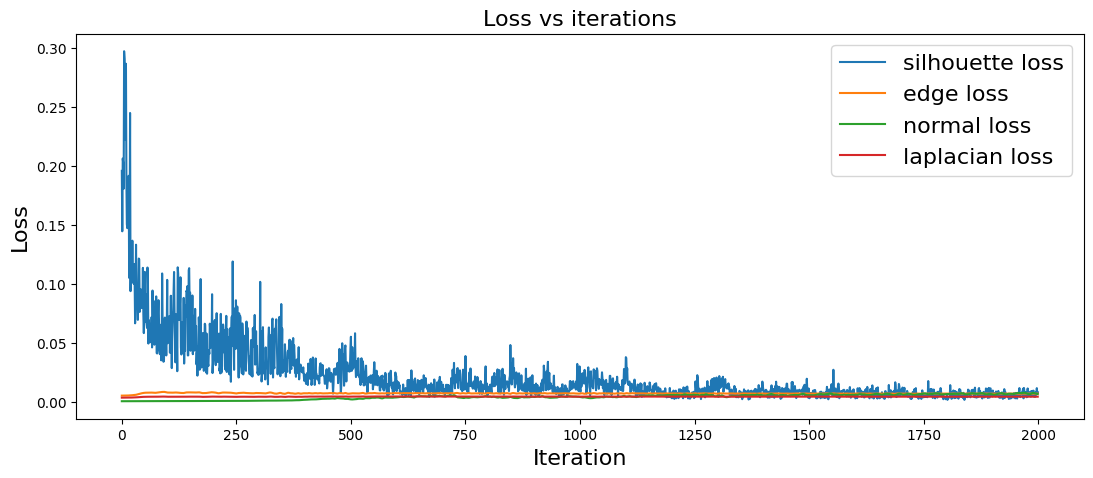

In [105]:
plot_losses(losses)

## Predicted deformed shape

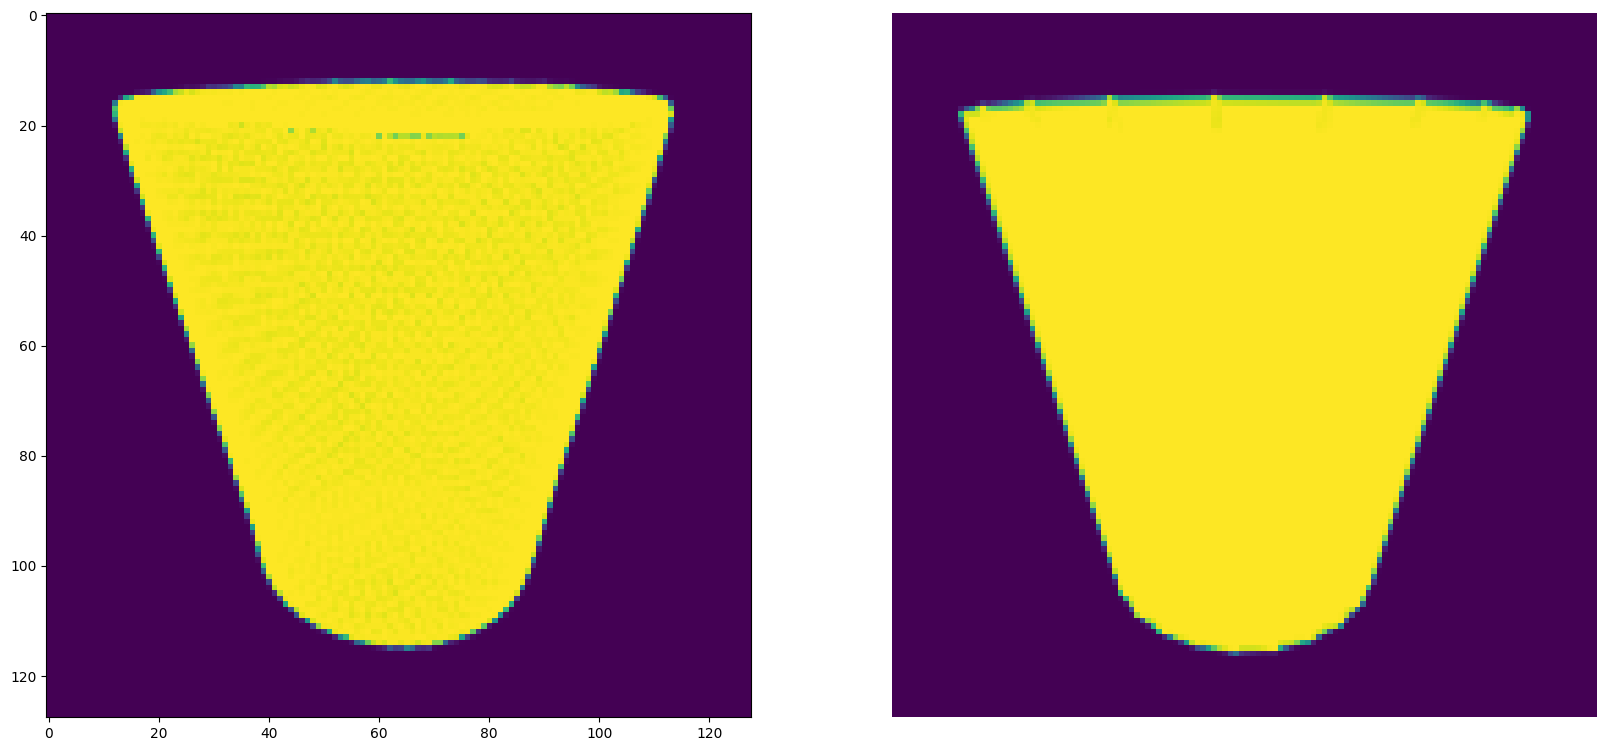

In [106]:
visualize_prediction(
    new_src_mesh,
    renderer=renderer_silhouette,
    target_image=target_silhouette[1],
    silhouette=True)

## Shapes comparison

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning:

No mtl file provided



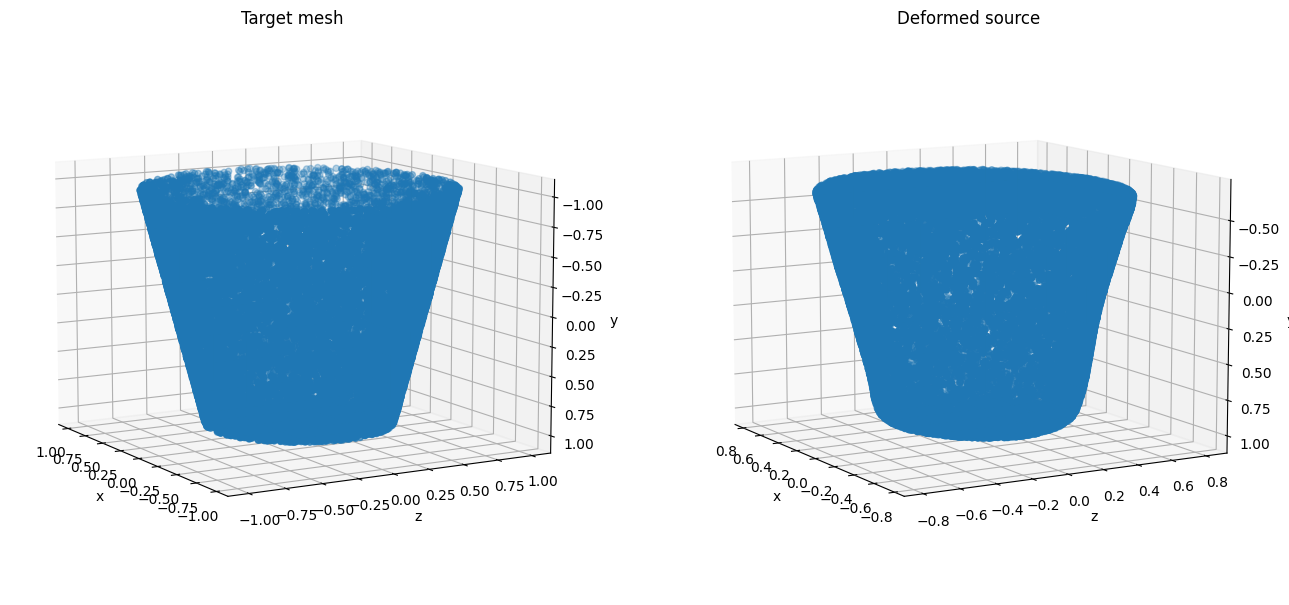

In [107]:
final_filename = "final_model.obj"
final_mesh = load_objs_as_meshes([final_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = final_mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
final_mesh.offset_verts_(-center)
final_mesh.scale_verts_((1.0 / float(scale)));

# Visualize mesh
final_pointcloud(src_mesh=mesh,final_mesh=final_mesh)

In [108]:
src_fig = mesh_visualization(meshes_paths[9])
final_fig = mesh_visualization("final_model.obj")

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'is_3d': True}, {'is_3d': True}]],
                    print_grid=False)

fig.append_trace(src_fig,row=1,col=1)
fig.append_trace(final_fig,row=1,col=2)
fig.update_layout(width=1000, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='cube')
# manually force the z-axis to appear twice as big as the other two
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=2))
# draw axes in proportion to the proportion of their ranges
fig.update_layout(scene_aspectmode='data')
# automatically produce something that is well proportioned using 'data' as the default
fig.update_layout(scene_aspectmode='auto')
fig.show()